In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt


In [116]:
customer_data = pd.read_csv("sales.csv")

print(customer_data.head())



   Unnamed: 0  store_ID  day_of_week        date  nb_customers_on_day  open  \
0      425390       366            4  2013-04-18                  517     1   
1      291687       394            6  2015-04-11                  694     1   
2      411278       807            4  2013-08-29                  970     1   
3      664714       802            2  2013-05-28                  473     1   
4      540835       726            4  2013-10-10                 1068     1   

   promotion state_holiday  school_holiday  sales  
0          0             0               0   4422  
1          0             0               0   8297  
2          1             0               0   9729  
3          1             0               0   6513  
4          1             0               0  10882  


In [117]:
# Visualize the data with correlation matrix
print("Shape of the data: ", customer_data.shape)
print("data types = ", customer_data.dtypes)
print(customer_data.describe())

Shape of the data:  (640840, 10)
data types =  Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object
          Unnamed: 0       store_ID    day_of_week  nb_customers_on_day  \
count  640840.000000  640840.000000  640840.000000        640840.000000   
mean   355990.675084     558.211348       4.000189           633.398577   
std    205536.290268     321.878521       1.996478           464.094416   
min         0.000000       1.000000       1.000000             0.000000   
25%    178075.750000     280.000000       2.000000           405.000000   
50%    355948.500000     558.000000       4.000000           609.000000   
75%    533959.250000     837.000000       6.000000           838.000000   
max    712044.000000    1115.000000    

In [118]:
missing_info = pd.DataFrame({
    "has_missing": customer_data.isna().any(),
    "missing_count": customer_data.isna().sum(),
    "missing_pct": (customer_data.isna().sum() / len(customer_data) * 100).round(2)
})
missing_info = missing_info[missing_info["has_missing"]]
print(missing_info)
cols_with_na = missing_info.index.tolist()


Empty DataFrame
Columns: [has_missing, missing_count, missing_pct]
Index: []


In [119]:
#Checking state-holiday values and conert to categorical
customer_data["state_holiday"].unique()
sh_dict = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
customer_data["state_holiday"] = customer_data["state_holiday"].map(sh_dict)



In [120]:
customer_data["state_holiday"].unique()

array([0, 1, 3, 2])

In [121]:
#1. Clean up and type-casting
#Drop the redundant index column
#The Unnamed: 0 column appears to be just the original row index. You can safely drop it:
customer_data = customer_data.drop(columns='Unnamed: 0')

#Convert date to datetime
#convert it so you can extract time-based features and do time‐series plots:
customer_data['date'] = pd.to_datetime(customer_data['date'])

In [122]:
# For second model approach : categorical approach
#Cast categorical fields
#Columns like day_of_week, open, promotion, state_holiday and school_holiday should be converted to category dtype in pandas. This both saves memory and makes plotting & grouping easier:

# for col in ['day_of_week','open','promotion','state_holiday','school_holiday']:
#    customer_data[col] = customer_data[col].astype('category')

In [123]:
#2. Feature engineering
#"Once your date is a datetime, you can create new features that often help boost model performance or reveal patterns in EDA:

#Temporal features

customer_data['year']   = customer_data['date'].dt.year
#customer_data['month']  = customer_data['date'].dt.month     # Data exploration show us that dow and month are highly correlated so we don't need to create column month 
customer_data['dow']    = customer_data['date'].dt.dayofweek  # Monday=0 … Sunday=6
customer_data['weekofyear'] = customer_data['date'].dt.isocalendar().week

customer_data = customer_data.drop(['date'], axis=1)

In [124]:
#Promotional lag features
#Capture whether a store was on promotion in the last 7 days, or count how many promo days in the past month.

customer_data = customer_data.sort_values(['store_ID','dow'])
customer_data['promo_7d'] = (customer_data
    .groupby('store_ID')['promotion']
    .rolling(window=7, min_periods=1).sum()
    .reset_index(0,drop=True))


In [125]:
#Checking stats after transformation and cleaning
print("Shape of the data: ", customer_data.shape)
print("data types = ", customer_data.dtypes)
print(customer_data.describe())

missing_info = pd.DataFrame({
    "has_missing": customer_data.isna().any(),
    "missing_count": customer_data.isna().sum(),
    "missing_pct": (customer_data.isna().sum() / len(customer_data) * 100).round(2)
})
missing_info = missing_info[missing_info["has_missing"]]
print(missing_info)
cols_with_na = missing_info.index.tolist()

Shape of the data:  (640840, 12)
data types =  store_ID                 int64
day_of_week              int64
nb_customers_on_day      int64
open                     int64
promotion                int64
state_holiday            int64
school_holiday           int64
sales                    int64
year                     int32
dow                      int32
weekofyear              UInt32
promo_7d               float64
dtype: object
            store_ID    day_of_week  nb_customers_on_day           open  \
count  640840.000000  640840.000000        640840.000000  640840.000000   
mean      558.211348       4.000189           633.398577       0.830185   
std       321.878521       1.996478           464.094416       0.375470   
min         1.000000       1.000000             0.000000       0.000000   
25%       280.000000       2.000000           405.000000       1.000000   
50%       558.000000       4.000000           609.000000       1.000000   
75%       837.000000       6.000000       

3. Exploratory plots
Some quick visualizations to understand your main drivers:
- Sales over time (all stores vs. sample store)
- Plot total daily sales aggregated across all stores.

Pick one or two stores at random and overlay their curves to see variability.

Effect of promotions
- Boxplot or violin plot of daily sales on promo vs. non-promo days.

<Axes: xlabel='promotion', ylabel='sales'>

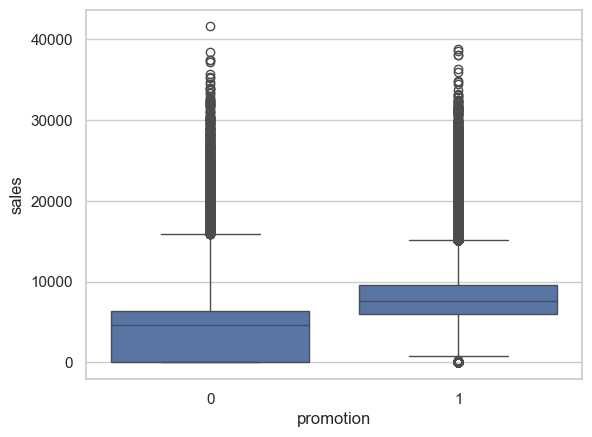

In [126]:
sns.boxplot(x='promotion', y='sales', data=customer_data)

Customer count vs. sales
- Scatterplot of nb_customers_on_day vs. sales to check linearity.

<Axes: xlabel='nb_customers_on_day', ylabel='sales'>

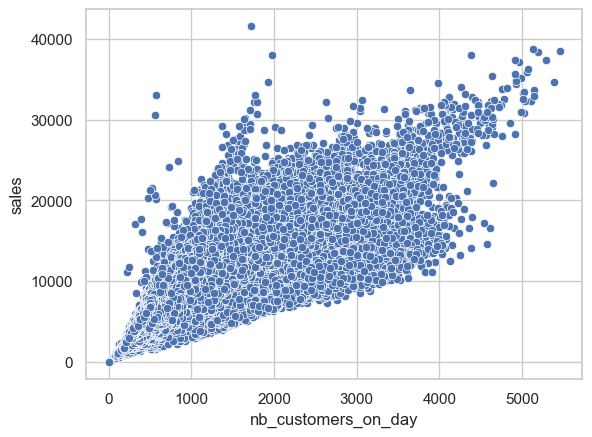

In [127]:
sns.scatterplot(x='nb_customers_on_day', y='sales', data=customer_data)


Day-of-week seasonality
- Bar chart of average sales by day_of_week.


<Axes: xlabel='dow', ylabel='sales'>

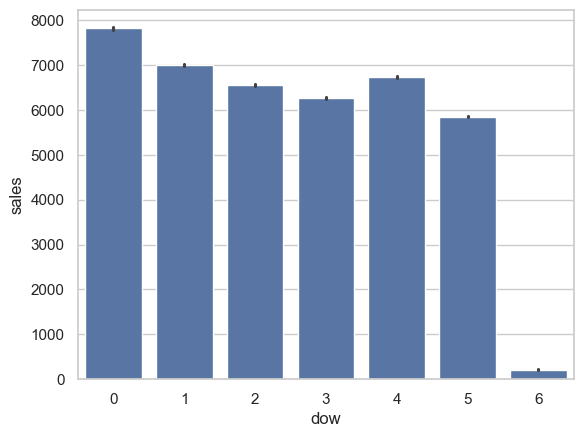

In [128]:

sns.barplot(x='dow', y='sales', data=customer_data, estimator=np.mean)


Holiday impact
- Compare average sales on state holidays vs. normal days.

In [129]:
avg_sales_by_holiday = customer_data.groupby('state_holiday')['sales'].mean()
print(avg_sales_by_holiday)

state_holiday
0    5952.206403
1     282.368167
2     252.936877
3     178.606707
Name: sales, dtype: float64


Correlation matrix

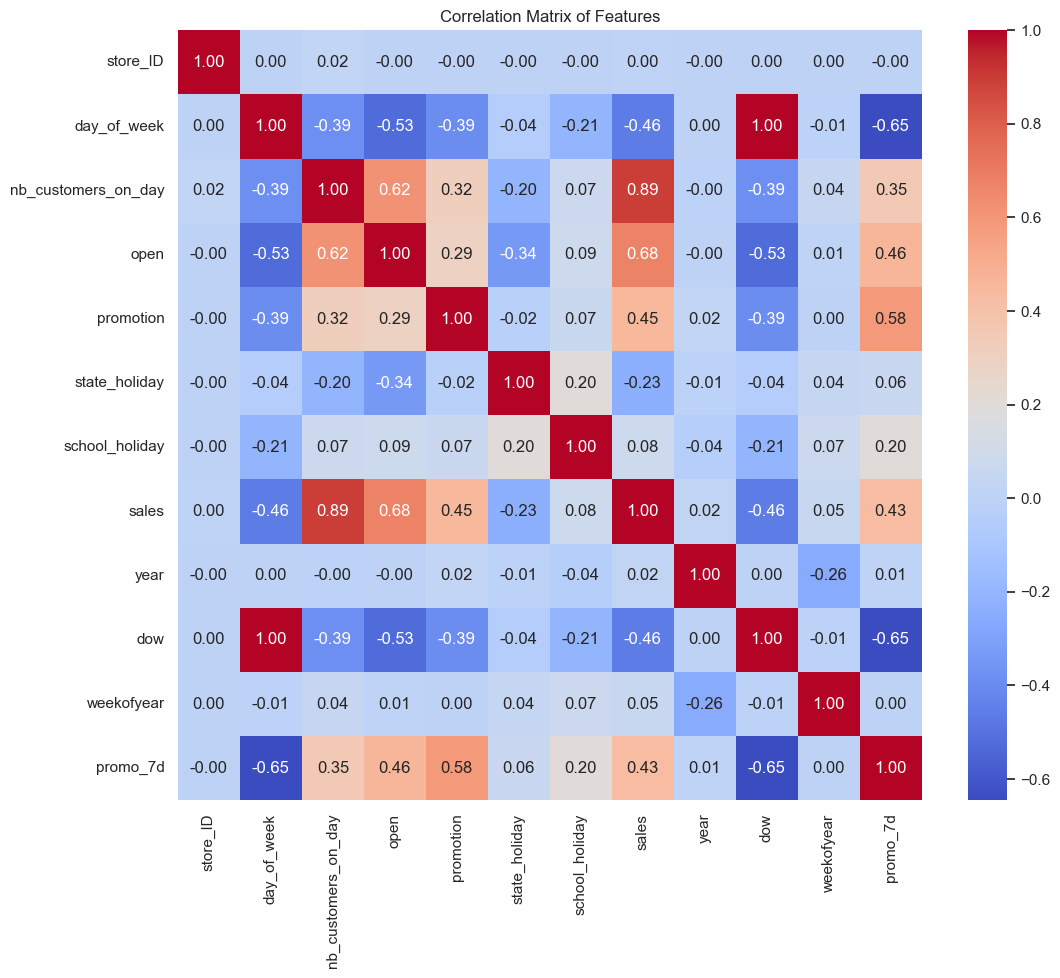

In [130]:
import matplotlib.pyplot as plt

correlation_matrix = customer_data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [131]:
def get_highly_correlated_pairs(corr_matrix: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    """
    Return a DataFrame of column pairs whose absolute correlation exceeds the given threshold.

    Parameters
    ----------
    corr_matrix : pd.DataFrame
        Square correlation matrix (e.g., from df.corr()).
    threshold : float, default 0.9
        Minimum absolute correlation value to include a pair.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['col1', 'col2', 'corr'], sorted by descending |corr|.
    """
    high_corr_pairs = []
    cols = corr_matrix.columns

    # Iterate over the upper triangle of the correlation matrix (excluding the diagonal)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            corr_value = corr_matrix.iat[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'col1': cols[i],
                    'col2': cols[j],
                    'corr': round(corr_value, 2)
                })

    # If no pairs found, return an empty DataFrame with appropriate columns
    if not high_corr_pairs:
        return pd.DataFrame(columns=['col1', 'col2', 'corr'])

    # Build DataFrame and sort by absolute correlation value in descending order
    df_pairs = pd.DataFrame(high_corr_pairs)
    df_pairs = df_pairs.reindex(
        df_pairs['corr'].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)

    return df_pairs

In [132]:
# On récupère toutes les paires |corr| > 0.9
df_corr_pairs = get_highly_correlated_pairs(correlation_matrix, threshold=0.9)

print(df_corr_pairs)


          col1 col2  corr
0  day_of_week  dow   1.0


In [133]:
# Removing column day of week
customer_data = customer_data.drop(['day_of_week'], axis=1)

In [134]:
customer_data.head()

,store_ID,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,dow,weekofyear,promo_7d
2525,1,681,1,1,0,0,5927,2013,0,47,1.0
13234,1,501,1,0,0,0,3965,2015,0,7,1.0
13992,1,723,1,1,0,0,7380,2014,0,49,2.0
26155,1,481,1,0,0,0,3826,2014,0,9,2.0
42580,1,669,1,1,0,0,5942,2015,0,10,3.0


In [135]:
customer_data.dtypes

store_ID                 int64
nb_customers_on_day      int64
open                     int64
promotion                int64
state_holiday            int64
school_holiday           int64
sales                    int64
year                     int32
dow                      int32
weekofyear              UInt32
promo_7d               float64
dtype: object

In [136]:
#XGBBOOST test:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [137]:
# Separate features and target variable
X = customer_data.drop('sales', axis=1)
y = customer_data['sales']


In [152]:
X_GB = customer_data.drop(columns=['sales'])
y_GB = customer_data['sales']
X_train, X_test, y_train, y_test = train_test_split(X_GB, y_GB, test_size=0.2, random_state=42)

In [159]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=100,              # number of trees
    learning_rate=0.1,             
    max_depth=6,                   
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [160]:
y_pred = model.predict(X_test)


In [161]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")




MSE: 1312873.000
RMSE: 1145.807
MAE: 781.045
R^2: 0.911


In [162]:
#MSE (Mean Squared Error): 1,312,873 — average squared difference between predicted and actual sales. Lower is better.
#RMSE (Root Mean Squared Error): 1145.8 — in the same units as your target (sales), so on average your predictions are about 1146 units off.
#MAE (Mean Absolute Error): 781 — on average, your predictions are off by about 781 units.
#R² (R-squared): 0.911 — your model explains about 91.1% of the variance in sales. That’s pretty high and indicates a good fit.

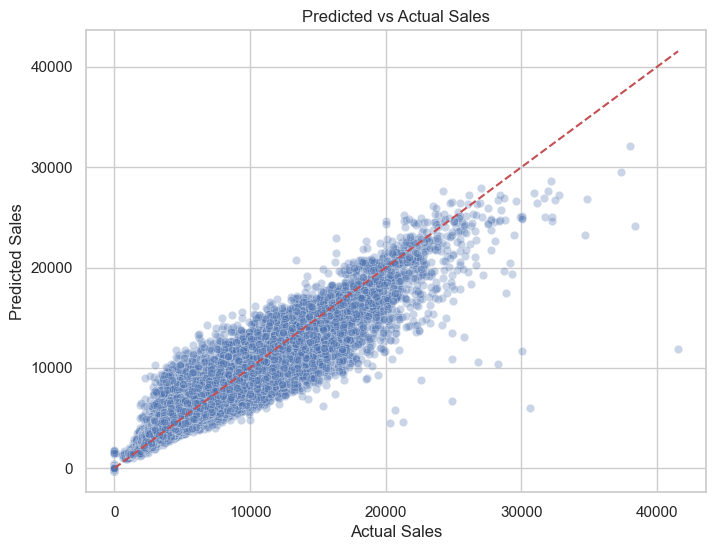

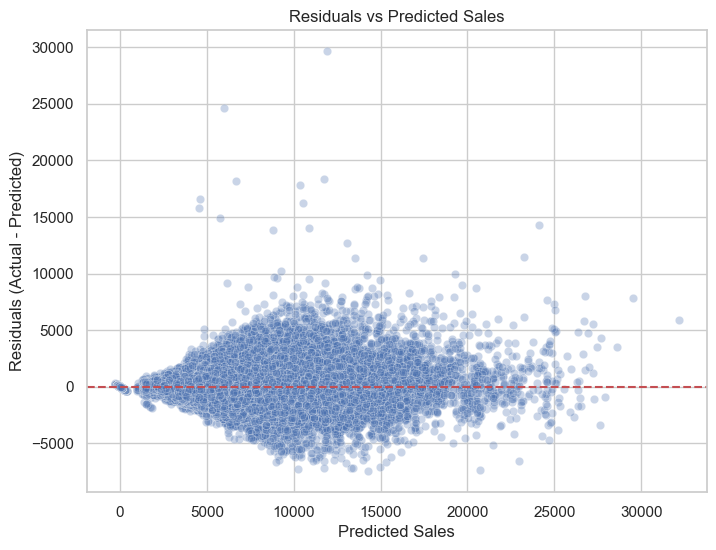

<Figure size 1000x600 with 0 Axes>

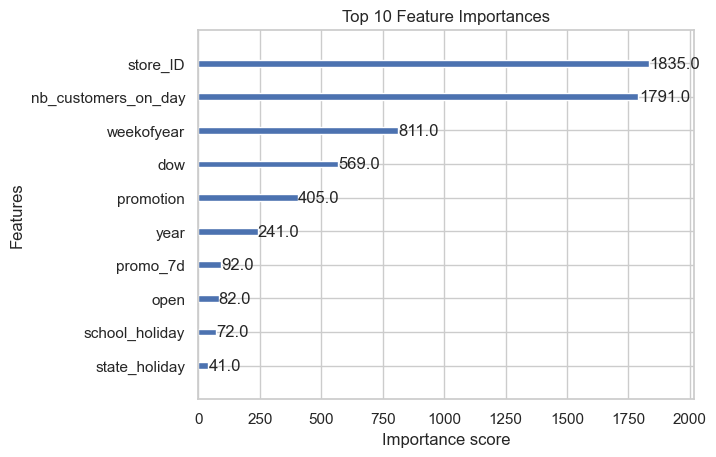

In [143]:
# 1. Predicted vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.show()

# 2. Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Sales")
plt.show()

# 3. Feature Importance
plt.figure(figsize=(10,6))
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importances")
plt.show()

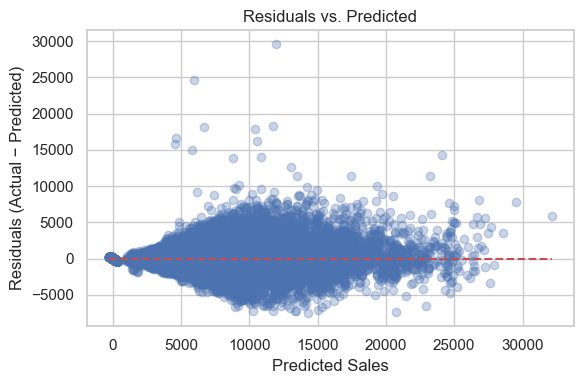

In [144]:
# 2) Residuals vs. Predicted
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals (Actual − Predicted)')
plt.title('Residuals vs. Predicted')
plt.tight_layout()
plt.show()

In [145]:
y_GB = np.log1p(customer_data['sales'])
X_GB = customer_data.drop(columns=['sales'])

X_train, X_test, y_train, y_test = train_test_split(X_GB, y_GB, test_size=0.2, random_state=42)

In [146]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [147]:
# Predict
y_pred_log = model.predict(X_test)

# Inverse log1p to get predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")




MSE: 1382488.110
RMSE: 1175.793
MAE: 780.290
R^2: 0.907


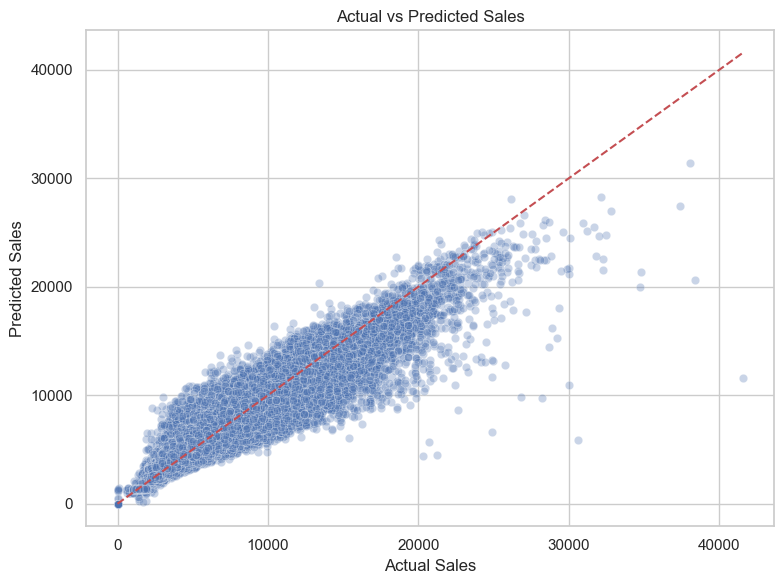

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.tight_layout()
plt.show()

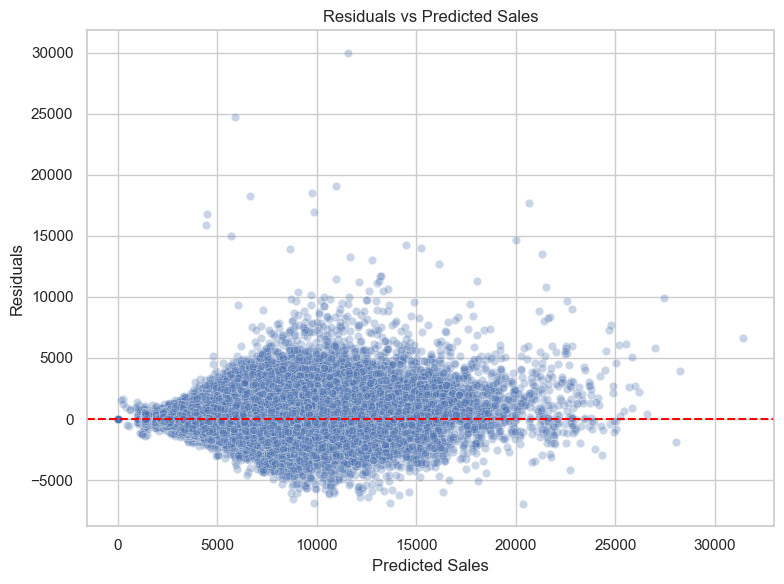

In [150]:
residuals = y_test_original - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.tight_layout()
plt.show()

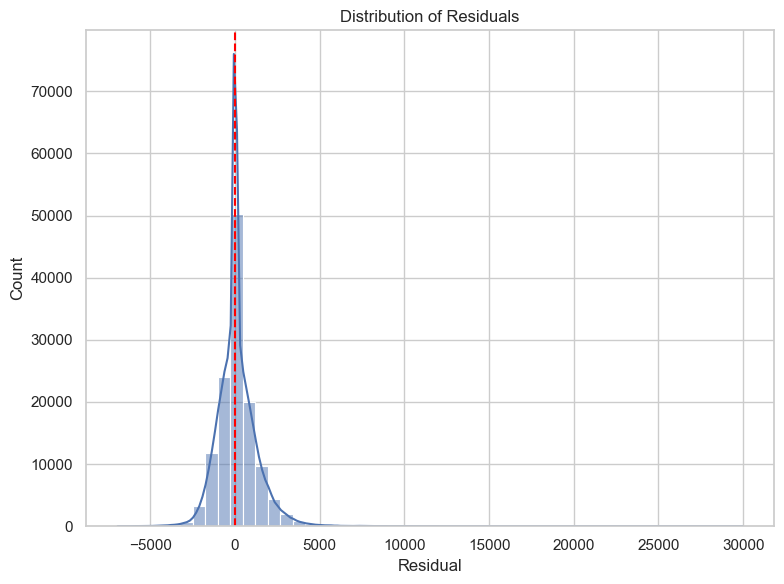

In [151]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()